# Лабораторная работа №3. Синтез БИХ-фильтров.
Курс: лаборатория цифровой обработки сигналов, МФТИ
# Модуль 1. Метод размещения нулей и полюсов.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import matplotlib.ticker as ticker
#%matplotlib inline
%matplotlib notebook

**Основная идея.** Значения $|H(z)|$ на единичной окружности отражают АЧХ фильтра:
$$A(\theta)=|H(e^{j\theta})|.$$

In [2]:
# Python класс для анализа фильтра
class Filter():
    def __init__(self, dlti_args, fs=1.0):
#         Инициализация на основе объекта signal.dlti
        self.fs = fs
        self.system_dlti=signal.dlti(*dlti_args, dt=1.0/fs)
        self.alpha_beta()
        self.zpk()
    def alpha_beta(self):
#         Вычисление коэффициентов alpha beta
        system = signal.TransferFunction(self.system_dlti)
        self.beta = system.num
        self.alpha = system.den
    def zpk(self):
#         Вычисление нулей, полюсов и множителя        
        system = self.system_dlti.to_zpk()
        self.zeros = system.zeros
        self.poles = system.poles
        self.gain = system.gain
    def zpk_plot(self):
#         Нуль-полюсная диаграмма
        plt.figure()
        q = np.linspace(0, 2*np.pi, 401)
        ax = plt.axes()
        ax.set_aspect(aspect='equal', adjustable='datalim')
        plt.plot(np.cos(q), np.sin(q), 'k--')  
        plt.plot(self.zeros.real, self.zeros.imag, 'ro', label='Нули')
        plt.plot(self.poles.real, self.poles.imag, 'bx', label='Полюса')
        plt.grid()
        plt.legend() #bbox_to_anchor=(1.05, 1), loc=2, numpoints=1
        plt.title("Нуль-полюсная диаграмма")
        plt.xlabel("Re $z$")
        plt.ylabel("Im $z$")
        plt.tight_layout()
        plt.show()
    def H(self, z):
#         Вычисление функции H(z) для заданного z. Требует предварительного вычисления нулей и полюсов.
        H = self.gain+0
        for z1 in self.zeros:
            H *= (z-z1)
        for p1 in self.poles:
            H /= (z-p1)
        return H
    
    def abs_H_plot(self):
#         Трехмерный график |H(z)|
        fig = plt.figure(dpi=160)
        ax = plt.axes(projection='3d')
        Re=np.arange(-1.2, 1.2, 0.1)
        Im=np.arange(-1.2, 1.2, 0.1)
        Re, Im = np.meshgrid(Re, Im)
        Z1=(Re+1j*Im)
        
        
        Z=abs(self.H(Z1))
        Z=np.minimum(Z, 40*np.ones(Z.shape))


        phi=np.linspace(0, 2*np.pi, 500)
        #ax.plot_surface(Re, Im, Z, linewidth=0, antialiased=True, color='silver')
        ax.plot_wireframe(Re, Im, Z, color='silver')

        for u in phi:
            Z1=np.exp(-1j*u)
            Z2=abs(self.H(Z1))
            ax.plot([Z1.real, Z1.real], [Z1.imag, Z1.imag], [0.0, Z2],  color=(abs(np.cos(u)), 0.7, 0.5))


        Z1=np.exp(-1j*phi)
        Z2=abs(self.H(Z1))

        ax.plot(Z1.real, Z1.imag, Z2, linewidth=2, color='b')

        ax.set_zlim(0, 1.2*max(Z2))
        ax.set_xticks(np.linspace(-1, 1, 5))
        ax.set_yticks(np.linspace(-1, 1, 5))
        ax.set_zticks(np.linspace(0, max(Z2), 5))
        ax.view_init(40, 240)
        ax.set_xlabel("Re $z$")
        ax.set_ylabel("Im $z$")

        ax.zaxis.set_rotate_label(False)  # disable automatic rotation
        ax.set_zlabel("$|H(z)|$", rotation=0)
        plt.tight_layout()
    def lfilter_resp(self, x):
#         Фильтрация заданного сигнала
        return signal.lfilter(self.beta, self.alpha, x)
    def lfilt_plot(self, x, label='y'):
        self.alpha_beta()
#         График сигнала на выходе фильтра при заданном входе
        y = self.lfilter_resp(x)
        plt.figure(figsize=[8, 3])
        plt.title("Сигнал на выходе фильтра")
        plt.stem(np.arange(y.shape[0]), y)
        plt.xlabel("$k$")
        plt.ylabel("$%s[k]$" %label)
        plt.tight_layout()
        plt.grid()
    def step_resp_plot(self, n=20):
        t, y = signal.dstep(self.system_dlti, n=n)
        plt.figure(figsize=[8, 3])
        plt.title("Переходная характеристика")
        y=np.squeeze(y)
        plt.stem(np.arange(len(y)), y)
        plt.xlabel("$k$")
        plt.ylabel("$g[k]$")
        plt.tight_layout()
        plt.grid()
    def impulse_resp_plot(self, n=20):
        t, y = signal.dimpulse(self.system_dlti, n=n)
        plt.figure(figsize=[8, 3])
        plt.title("Импульсная характеристика")
        y=np.squeeze(y)
        plt.stem(np.arange(len(y)), y)
        plt.xlabel("$k$")
        plt.ylabel("$h[k]$")
        plt.tight_layout()
        plt.grid()
    def freqresp_plot(self, f_scale='f', whole=True):
#         АЧХ фильтра
        w, H = self.system_dlti.freqresp(w=None, n=2**18, whole=whole)
        if whole:
            w, H = w-np.pi, np.fft.fftshift(H)
        figure1 = plt.figure(figsize=[8, 6])
        ax1 = plt.subplot(2, 1, 1)
        ax2 = plt.subplot(2, 1, 2)
        
        
        
        for ax in [ax1, ax2]:
            if f_scale=='f':
                f = self.fs*(w/(2*np.pi))/1e3
                ax.set_xlabel("$f$, кГц")    
            elif f_scale=='\\nu':
                f = w/(2*np.pi)
                ax.set_xlabel("$%s$" % f_scale)
            elif f_scale=='\\theta':
                f = w
                ax.set_xlabel("$%s$, рад" % f_scale) 
            ax.set_xlim([f[0], f[-1]])
            ax.grid()
            
        ax1.set_title("AЧХ фильтра")    
        ax1.plot(f, abs(H))
        ax1.set_ylabel("$|H(%s)|$" % f_scale)
        
        
        ax2.plot(f, np.angle(H))
        ax2.set_ylabel("$\\varphi(%s)$" % f_scale)
        ax2.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], labels=("$-\\pi$", "$-\\pi/2$", "$0$", "$\\pi/2$", "$\\pi$"))
        plt.tight_layout()
        

In [3]:
f1=Filter(dlti_args=([np.exp(2j*np.pi*0.1), np.exp(-2j*np.pi*0.1)], [0, 0.9], 1), fs=1e3)

<IPython.core.display.Javascript object>


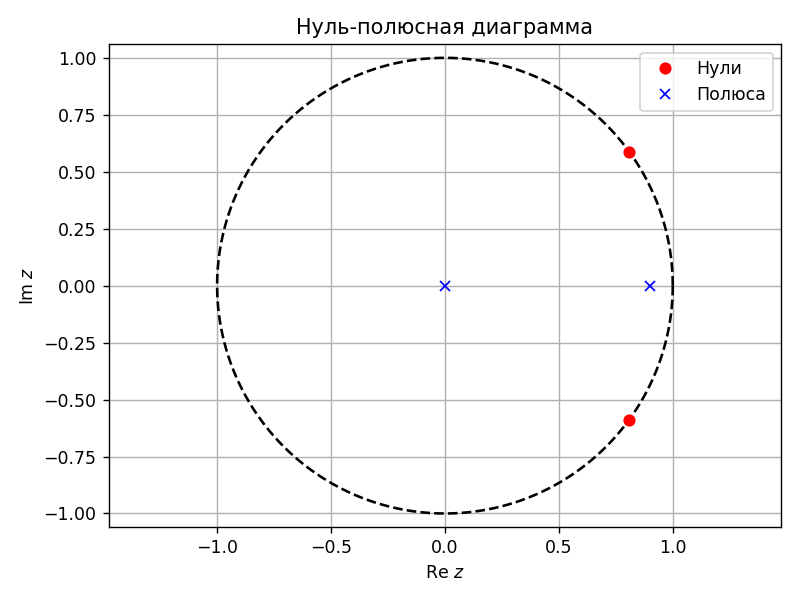

In [4]:
f1.zpk_plot()

<IPython.core.display.Javascript object>


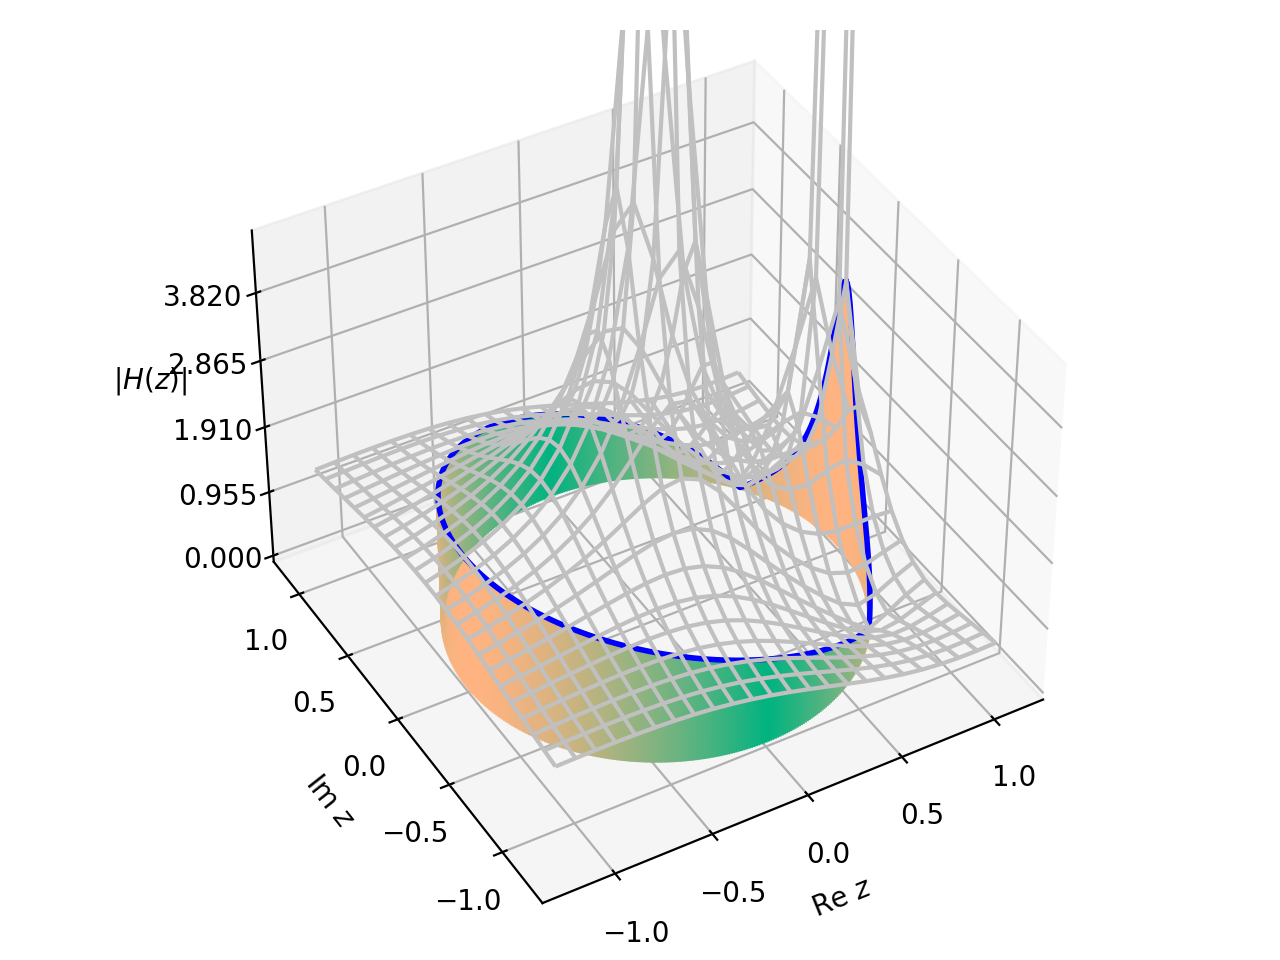

In [5]:
f1.abs_H_plot()

<IPython.core.display.Javascript object>


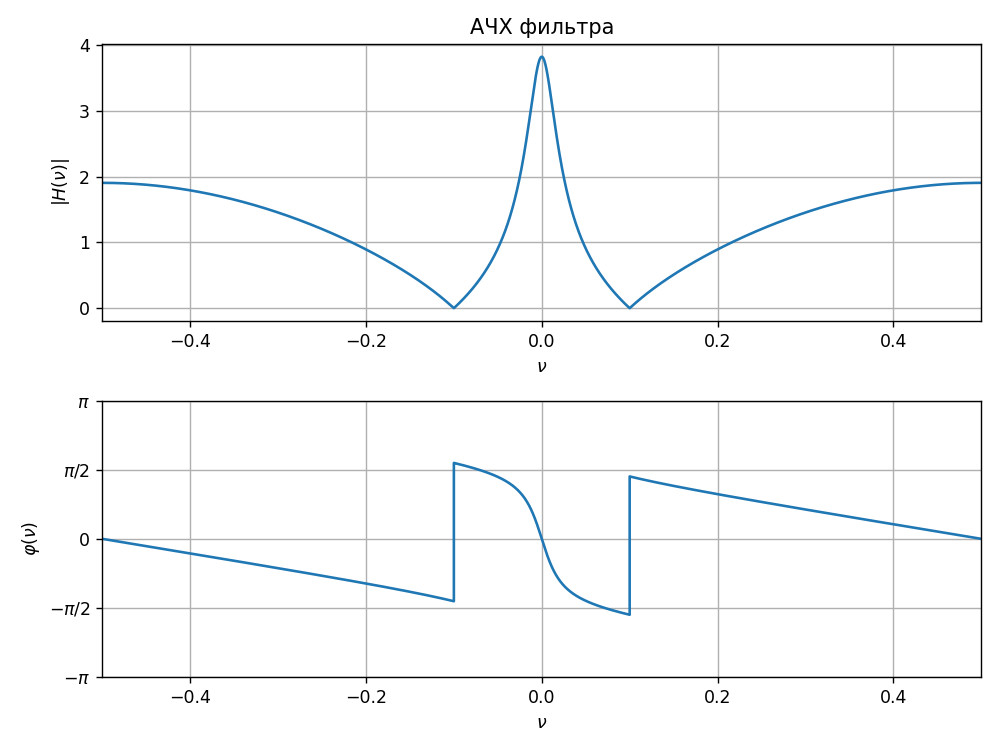

In [6]:
f1.freqresp_plot(f_scale='\\nu')

<IPython.core.display.Javascript object>


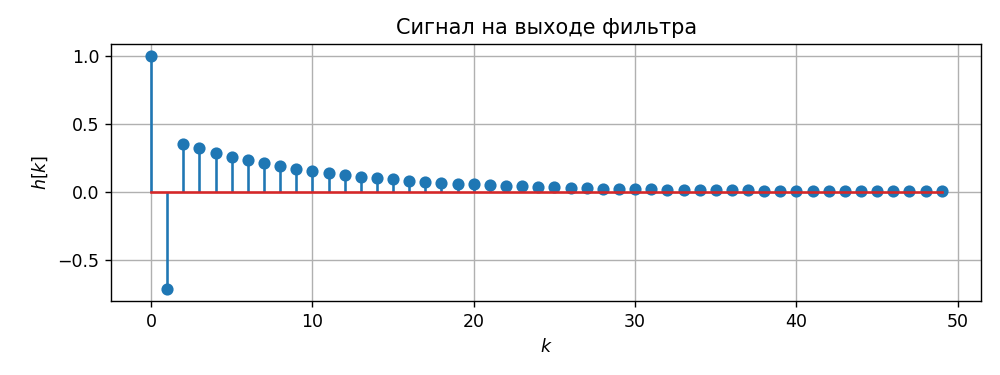

In [7]:
f1.lfilt_plot(signal.unit_impulse(50),label='h')

<IPython.core.display.Javascript object>


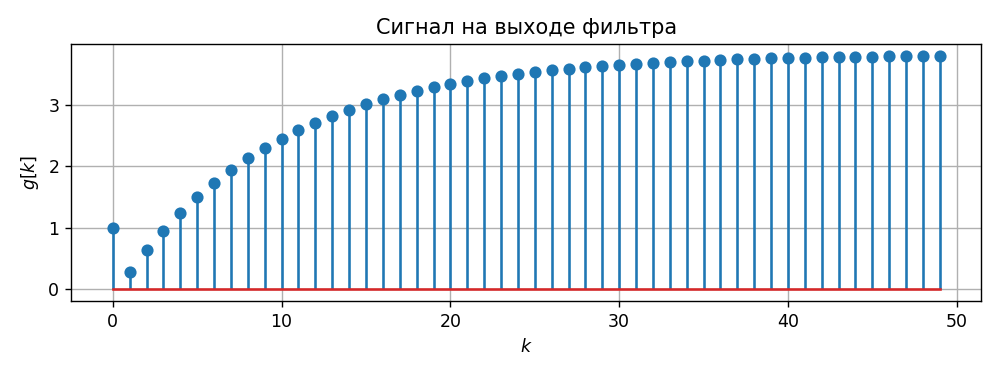

In [8]:
f1.lfilt_plot(np.ones(50),label='g')

<IPython.core.display.Javascript object>


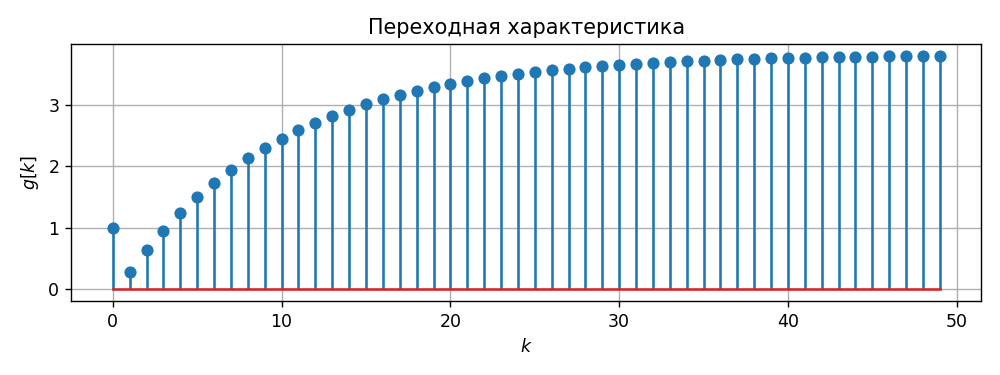

In [9]:
f1.step_resp_plot(n=50)

<IPython.core.display.Javascript object>


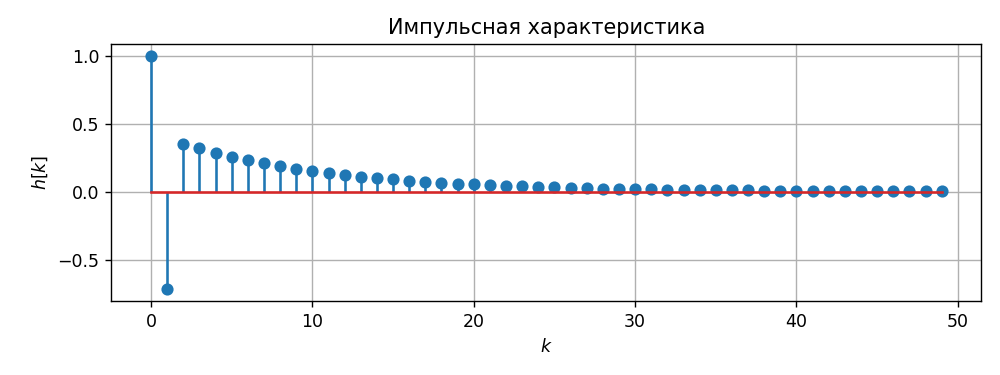

In [10]:
f1.impulse_resp_plot(n=50)

Библиотечные функции **signal.iirnotch и signal.iirpeak**

In [11]:
fs = 200.0  # Sample frequency (Hz)
f0 = 60.0  # Frequency to be removed from signal (Hz)
Q = 30.0  # Quality factor
# Design notch filter
beta1, alpha1 = signal.iirnotch(f0, Q, fs)
beta2, alpha2  = signal.iirpeak(f0, Q, fs)

### Задача 1.1 Синтез цифрового резонатора

| Варианты: |   $1$ |    $2$ |    $3$ |    $4$ |    $5$ |    $6$ |     $7$ |    $8$ |    $9$ |    $10$ | 
|:---------:|----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|
|  $\nu_0$  | $0.25$ | $0.2$ | $0.1$ |  $—$ | $—$ | $—$ | $0.3$ | $0.15$ | $0.35$ | $0.4$ |
|$\theta_0$ | $—$ | $—$ | $—$ | $\dfrac\pi6$ | $\dfrac\pi3$ | $\dfrac\pi2$ |  $—$ | $—$ | $—$ | $—$ |

Синтезировать методом размещения нулей и полюсов цифровой резонатор для частоты $\nu_0$ или $\theta_0$ (в зависимости от варианта). Параметр, влияющий на добротность резонатора, подобрать самостоятельно.

* Построить нуль-полюсную диаграмму получившегося фильтра.
* Записать передаточную функцию $H(z)$.
* Вычислить аналитически импульсную и переходную характеристики и сравнить с результатами моделирования.
* Исследовать фильтр на устойчивость по входу.
* Изобразить блок-схему фильтра.
* Построить АЧХ и ФЧХ фильтра.
* Сравнить АЧХ с $H(z)$.

### Задача 1.2 Синтез цифрового фильтра Hum removal

| Варианты: |   1 |    2 |    3 |    4 |    5 |    6 |    7 |    8 |    9 |   10 |  
|:---------:|----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|
|  $f_0$, Гц  | 250 | 350 | 400 |  200 | 100 | 150 | 250 | 500| 600 | 350 |
|  $f_д$, Гц | 1000 | 1000 | 1000 | 500 | 500 | 500 | 1000 | 2000 | 2000 | 2000 |

Синтезировать методом размещения нулей и полюсов цифровой фильтр Hum removal  для частоты $f_{0}$, $f_{д}$. Параметр, влияющий на добротность, подобрать самостоятельно.

* Записать передаточную функцию $H(z)$.
* Исследовать фильтр на устойчивость по входу.
* Изобразить блок-схему фильтра.
* Построить АЧХ и ФЧХ фильтра.
* Сравнить АЧХ с $H(z)$.


### Пример. Сумма двух синусоидальных сигналов.

In [56]:
class Oscilloscope_signal():
    def __init__(self, file, label="x", const_level=0):
        self.label=label
        f = open(file)
        str1 = f.read().split('\n')
        f.closed
        # dt
        val, unit = str1[1].replace(',', '.').split(' ')[3:5]
        val=float(val)
        if unit=='uS':
            val*=1e-6
        elif unit=='nS':
            val*=1e-9
        elif unit=='mS':
            val*=1e-3    
        self.fs = int(1.0 / val)
        #Voltage step 
        val, unit = str1[2].replace(',', '.').split(' ')[3:5]
        dv=float(val)
        if unit=='mV':
            dv*=1e-3  
        # Zero level
        zero_level= int(str1[3].split(' ')[3])
        str_num = len(str1)
        self.signal = np.empty(shape=(str_num-8), dtype=float)
        for k, u in enumerate(range(7, str_num-1, 1)):
            data = str1[u].split()
            self.signal[k]=(int(data[1])-zero_level)*dv-const_level
    def plot_signal(self):
        plt.figure(figsize=[8, 4])
        plt.stem(np.arange(self.signal.shape[0]), self.signal)
        plt.xlabel("$k$")
        plt.ylabel("$%s[k]$" %self.label)
        plt.tight_layout()
    def plot_magnitude_response(self, db=False):
        Q=2**18
        Xn=np.fft.fft(self.signal, max(len(self.signal), Q))
        f = np.arange(0, self.fs/2, self.fs/Q)/1e3
        plt.figure(figsize=[8, 4])
        Xf = abs(Xn[0:f.size])
        if db:
            Xf_max=max(Xf)
            plt.plot(f, 20*np.log10(Xf/Xf_max))
            plt.ylabel("АЧХ, дБ")
        else:
            plt.plot(f, Xf)
            plt.ylabel("$|%s(f)|$" %self.label.upper())
        plt.xlabel("$f$, кГц")
        plt.tight_layout()
        plt.grid()
    def filtering(self, dfilter):
        self.signal = dfilter.lfilter(self.signal)

        

<IPython.core.display.Javascript object>


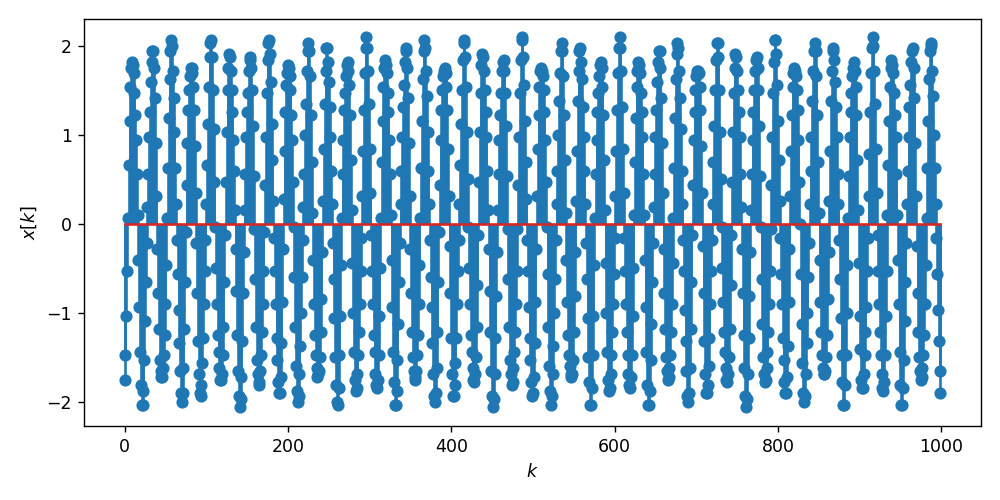

<IPython.core.display.Javascript object>


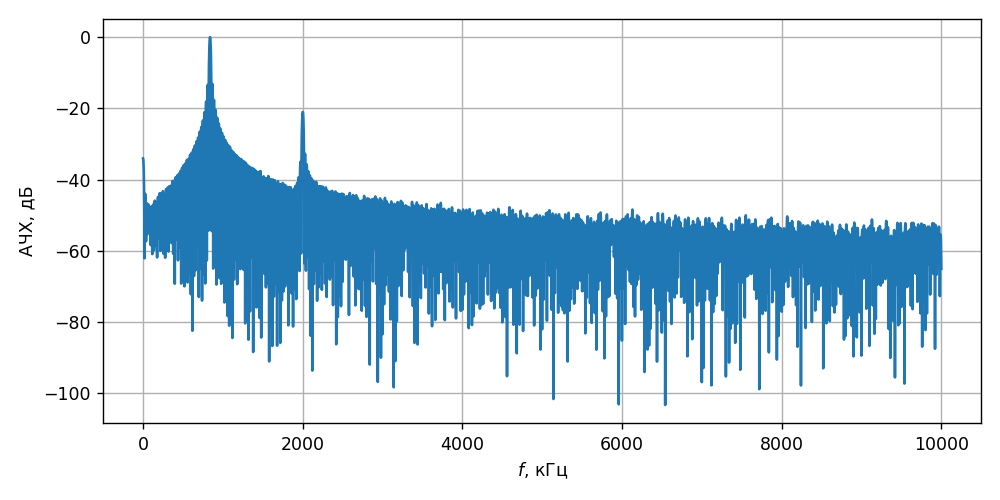

<IPython.core.display.Javascript object>


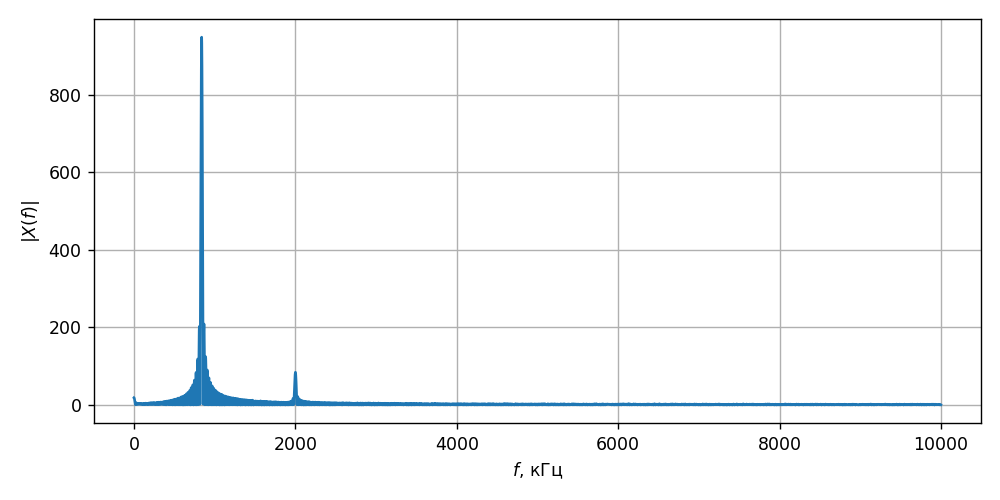

In [60]:
s1=Oscilloscope_signal('sum2.txt', label='x')
s1.plot_signal()
s1.plot_magnitude_response(db=True)
s1.plot_magnitude_response(db=False)

<IPython.core.display.Javascript object>


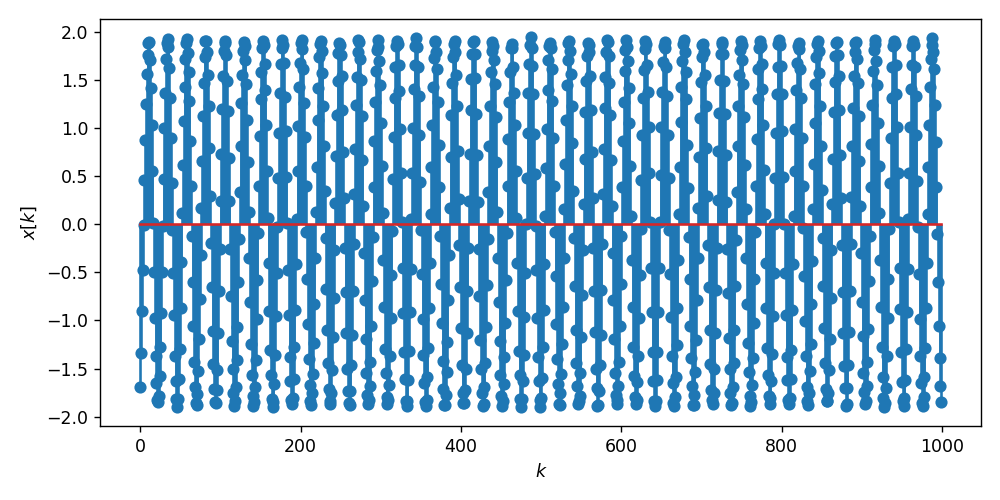

<IPython.core.display.Javascript object>


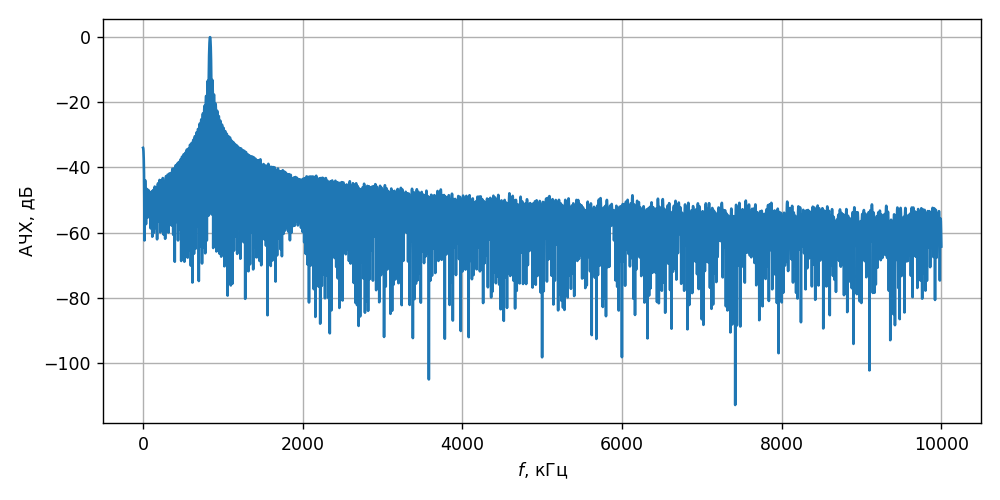

<IPython.core.display.Javascript object>


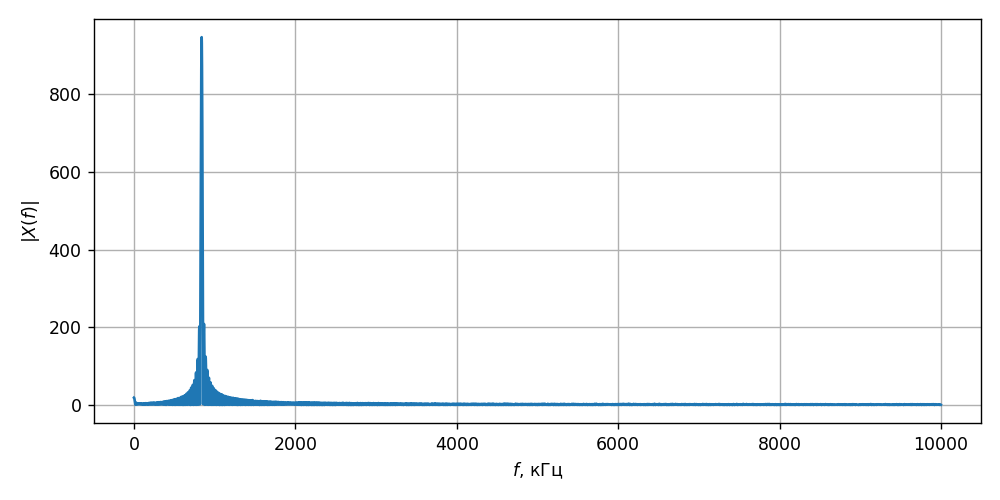

In [61]:
fs = s1.fs  # Sample frequency (Hz)
f0 = 2*1e6  # Frequency to be removed from signal (Hz)
Q = 10.0  # Quality factor
# Design notch filter
beta, alpha = signal.iirnotch(f0, Q, fs)
f1=Filter(dlti_args=(beta, alpha), fs=fs)
s1.signal = f1.lfilter_resp(s1.signal)
s1.plot_signal()
s1.plot_magnitude_response(db=True)
s1.plot_magnitude_response(db=False)

<IPython.core.display.Javascript object>


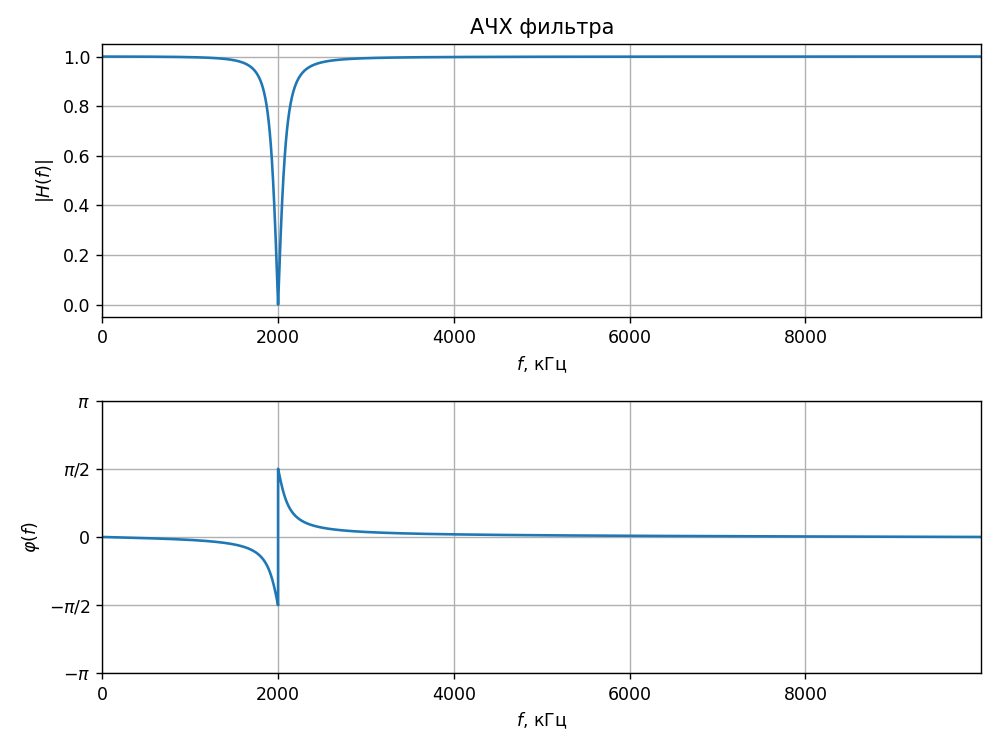

In [62]:
f1.freqresp_plot(f_scale='f', whole=False)